# Taxi Trip Duration Prediction Part 2

***

## Import Libraries

In [1]:
import numpy as np
from numpy import count_nonzero, median, mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
#import squarify


import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
# Import variance_inflation_factor from statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Import Tukey's HSD function
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import datetime
from datetime import datetime, timedelta, date

# import shap
# import eli5
# from IPython.display import display

#import os
#import zipfile
import scipy
from scipy import stats
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
from collections import Counter

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures

from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, GridSearchCV
from sklearn.model_selection import KFold, cross_val_predict, RandomizedSearchCV, StratifiedShuffleSplit

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.feature_selection import f_regression, f_classif, SelectKBest, SelectFromModel, chi2, RFE, RFECV
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold, SelectPercentile, GenericUnivariateSelect

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, LogisticRegression, Ridge

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# This module lets us save our models once we fit them.
# import pickle

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Quick Data Glance

In [2]:
df = pd.read_csv("nyctaximodnorm.csv")

In [3]:
df.head()

,vendorid2,paymenttype1,paymenttype2,pulocationid237,pulocationid161,pulocationid236,pulocationid186,pulocationid162,dolocationid161,dolocationid236,dolocationid237,dolocationid230,dolocationid170,tpeppickupdatetimehour0,tpeppickupdatetimehour1,tpeppickupdatetimehour2,tpepdropoffdatetimehour0,tpepdropoffdatetimehour1,tpepdropoffdatetimehour2,passengercount,tripdistance,fareamount,tipamount,totalamount,duration
0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.00,0.54,0.49,0.45,0.53,844.00
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.17,0.29,0.60,0.66,0.67,1560.00
2,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0.17,0.16,0.25,0.24,0.28,432.00
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.17,0.71,0.62,0.00,0.57,1003.00
4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1.00,0.37,0.34,0.34,0.40,480.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19692 entries, 0 to 19691
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vendorid2                 19692 non-null  int64  
 1   paymenttype1              19692 non-null  int64  
 2   paymenttype2              19692 non-null  int64  
 3   pulocationid237           19692 non-null  int64  
 4   pulocationid161           19692 non-null  int64  
 5   pulocationid236           19692 non-null  int64  
 6   pulocationid186           19692 non-null  int64  
 7   pulocationid162           19692 non-null  int64  
 8   dolocationid161           19692 non-null  int64  
 9   dolocationid236           19692 non-null  int64  
 10  dolocationid237           19692 non-null  int64  
 11  dolocationid230           19692 non-null  int64  
 12  dolocationid170           19692 non-null  int64  
 13  tpeppickupdatetimehour0   19692 non-null  int64  
 14  tpeppi

In [5]:
df.dtypes.value_counts()

int64      19
float64     6
dtype: int64

In [6]:
# Descriptive Statistical Analysis
df.describe(include=["int", "float"])

,vendorid2,paymenttype1,paymenttype2,pulocationid237,pulocationid161,pulocationid236,pulocationid186,pulocationid162,dolocationid161,dolocationid236,dolocationid237,dolocationid230,dolocationid170,tpeppickupdatetimehour0,tpeppickupdatetimehour1,tpeppickupdatetimehour2,tpepdropoffdatetimehour0,tpepdropoffdatetimehour1,tpepdropoffdatetimehour2,passengercount,tripdistance,fareamount,tipamount,totalamount,duration
count,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00,19692.00
mean,0.56,0.67,0.33,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.18,0.40,0.39,0.17,0.40,0.40,0.27,0.30,0.37,0.22,0.39,693.83
std,0.50,0.47,0.47,0.20,0.20,0.19,0.19,0.19,0.20,0.19,0.19,0.18,0.18,0.38,0.49,0.49,0.38,0.49,0.49,0.21,0.20,0.17,0.21,0.17,423.59
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.15,0.23,0.00,0.27,367.00
50%,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.24,0.32,0.21,0.36,600.00
75%,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,0.33,0.39,0.45,0.35,0.49,909.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2535.00


In [7]:
df.shape

(19692, 25)

In [8]:
df.columns

Index(['vendorid2', 'paymenttype1', 'paymenttype2', 'pulocationid237', 'pulocationid161', 'pulocationid236', 'pulocationid186', 'pulocationid162', 'dolocationid161', 'dolocationid236', 'dolocationid237', 'dolocationid230', 'dolocationid170', 'tpeppickupdatetimehour0', 'tpeppickupdatetimehour1', 'tpeppickupdatetimehour2', 'tpepdropoffdatetimehour0', 'tpepdropoffdatetimehour1', 'tpepdropoffdatetimehour2', 'passengercount', 'tripdistance', 'fareamount', 'tipamount', 'totalamount', 'duration'], dtype='object')

***

## Create a small dataset

In [ ]:
df = df.sample(frac=0.2)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

In [ ]:
df.shape

##  Linear Regression 

Let's first understand what exactly `Regression` means it is a statistical method used in finance, investing, and other disciplines that attempts to determine the `strength` and `character` of the relationship between one `dependent variable` (usually denoted by `Y`) and a series of other variables known as `independent variables`.   
`Linear Regression` is a statistical technique where based on a set of `independent variable(s)` a dependent variable is `predicted`. 

$$\huge y_{i} =\beta _{0} + \beta _{1} X_{i} + \varepsilon_{i}$$

y = dependent variable     
$ \beta_{0}$ = population of intercept    
$ \beta_{i}$ = population of co-efficient   
x = independent variable    
$ \varepsilon_{i}$ = Random error   


***

# Multiple Linear Regression 
It(as the name suggests) is characterized by `multiple independent variables` (more than `1`). While you discover the simplest `fit line`, you'll be able to adjust a `polynomial or regression` toward the `mean`. And these are called `polynomial or regression` toward the `mean`.

## Multiple Linear Regression (Scikit Learn)

<p>What if we want to predict car price using more than one variable?</p>

<p>If we want to use more variables in our model to predict car price, we can use <b>Multiple Linear Regression</b>.
Multiple Linear Regression is very similar to Simple Linear Regression, but this method is used to explain the relationship between one continuous response (dependent) variable and <b>two or more</b> predictor (independent) variables.
Most of the real-world regression models involve multiple predictors. We will illustrate the structure by using four predictor variables, but these results can generalize to any integer:</p>

$$
Y: Response \ Variable\\\\\\\\\\
X\_1 :Predictor\ Variable \ 1\\\\
X\_2: Predictor\ Variable \ 2\\\\
X\_3: Predictor\ Variable \ 3\\\\
X\_4: Predictor\ Variable \ 4\\\\
$$


$$
a: intercept\\\\\\\\\\
b\_1 :coefficients \ of\ Variable \ 1\\\\
b\_2: coefficients \ of\ Variable \ 2\\\\
b\_3: coefficients \ of\ Variable \ 3\\\\
b\_4: coefficients \ of\ Variable \ 4\\\\
$$

The equation is given by:

$$
Yhat = a + b\_1 X\_1 + b\_2 X\_2 + b\_3 X\_3 + b\_4 X\_4
$$


In [9]:
df.shape

(19692, 25)

In [10]:
df.head()

,vendorid2,paymenttype1,paymenttype2,pulocationid237,pulocationid161,pulocationid236,pulocationid186,pulocationid162,dolocationid161,dolocationid236,dolocationid237,dolocationid230,dolocationid170,tpeppickupdatetimehour0,tpeppickupdatetimehour1,tpeppickupdatetimehour2,tpepdropoffdatetimehour0,tpepdropoffdatetimehour1,tpepdropoffdatetimehour2,passengercount,tripdistance,fareamount,tipamount,totalamount,duration
0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.00,0.54,0.49,0.45,0.53,844.00
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.17,0.29,0.60,0.66,0.67,1560.00
2,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0.17,0.16,0.25,0.24,0.28,432.00
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.17,0.71,0.62,0.00,0.57,1003.00
4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1.00,0.37,0.34,0.34,0.40,480.00


In [42]:
X = df.iloc[:,0:24]
y = df.iloc[:,24]

In [43]:
X.values, y.values

(array([[1.        , 1.        , 0.        , ..., 0.49056604, 0.45320197,
         0.53488372],
        [0.        , 1.        , 0.        , ..., 0.60377358, 0.65681445,
         0.67183463],
        [0.        , 1.        , 0.        , ..., 0.24528302, 0.23809524,
         0.28262274],
        ...,
        [1.        , 0.        , 1.        , ..., 0.16981132, 0.        ,
         0.17118863],
        [1.        , 1.        , 0.        , ..., 0.39622642, 0.27914614,
         0.41989664],
        [0.        , 1.        , 0.        , ..., 0.41509434, 0.38587849,
         0.45704134]]),
 array([ 844., 1560.,  432., ...,  240.,  716.,  840.]))

## Feature selection

Feature selection is the process of choosing features to be used for modeling. In practice, feature selection takes place at multiple points in the PACE process. Although sometimes you will be given a dataset and a defined target variable, most often in practice you will begin with only a question or a problem that you are tasked with solving. In these cases, if you decide that the problem requires a model, you'll then have to:

* Consider what data is available to you
* Decide on what kind of model you need
* Decide on a target variable
* Assemble a collection of features that you think might help predict on your chosen target

This would all take place during the **Plan** phase. 

Then, during the **Analyze** phase, you would perform EDA on the data and reevaluate your variables for appropriateness. For example, can your model handle null values? If not, what do you do with features with a lot of nulls? Perhaps you drop them. This too is feature selection.

But it doesn't end there. Feature selection also occurs during the **Construct** phase. This usually involves building a model, examining which features are most predictive, and then removing the unpredictive features.

There's a lot of work involved in feature selection. In our case, we already have a dataset, and we're not performing thorough EDA on it. But we can still examine the data to ensure that all the features can reasonably be expected to have predictive potential. 

### F Test : Univariate linear regression tests returning F-statistic and p-values

In [13]:
# We will look into: f_regression
# f_regression finds the F-statistics for the *simple* regressions created with each of the independent variables
# In our case, this would mean running a simple linear regression on GPA where SAT is the independent variable
# and a simple linear regression on GPA where Rand 1,2,3 is the indepdent variable
# The limitation of this approach is that it does not take into account the mutual effect of the two features

f_regression(X,y)

# There are two output arrays
# The first one contains the F-statistics for each of the regressions
# The second one contains the p-values of these F-statistics

(array([     7.25833489,     32.06669811,     27.78327191,     25.45024332,
             4.07699091,     44.88486364,     36.67346778,      4.47215696,
             3.07817734,     64.62060457,     35.61123369,     13.64173392,
            14.94237265,    284.00078003,    191.98736193,      1.18483939,
           364.2390683 ,    174.98375122,      7.65658506,      0.42540614,
         20342.73915597, 156771.77290142,   3221.43239598,  94956.19093193]),
 array([0.00706325, 0.00000002, 0.00000014, 0.00000046, 0.04348453,
        0.        , 0.        , 0.034464  , 0.07936496, 0.        ,
        0.        , 0.00022181, 0.0001112 , 0.        , 0.        ,
        0.27638631, 0.        , 0.        , 0.00566183, 0.51425935,
        0.        , 0.        , 0.        , 0.        ]))

In [14]:
# Since we are more interested in the latter (p-values), we can just take the second array
p_values = f_regression(X,y)[1]
p_values

array([0.00706325, 0.00000002, 0.00000014, 0.00000046, 0.04348453,
       0.        , 0.        , 0.034464  , 0.07936496, 0.        ,
       0.        , 0.00022181, 0.0001112 , 0.        , 0.        ,
       0.27638631, 0.        , 0.        , 0.00566183, 0.51425935,
       0.        , 0.        , 0.        , 0.        ])

In [15]:
# To be able to quickly evaluate them, we can round the result to 3 digits after the dot
p_values.round(3)

array([0.007, 0.   , 0.   , 0.   , 0.043, 0.   , 0.   , 0.034, 0.079,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.276, 0.   , 0.   ,
       0.006, 0.514, 0.   , 0.   , 0.   , 0.   ])

In [16]:
pvaluesdf = pd.DataFrame(data=p_values, columns=['p-value'])
pvaluesdf

,p-value
0,0.01
1,0.00
2,0.00
3,0.00
4,0.04
5,0.00
6,0.00
7,0.03
8,0.08
9,0.00


In [17]:
# A list of columns with p-values

featuredf = pd.DataFrame(data=X.columns, columns=["feature"])
featuredf

,feature
0,vendorid2
1,paymenttype1
2,paymenttype2
3,pulocationid237
4,pulocationid161
5,pulocationid236
6,pulocationid186
7,pulocationid162
8,dolocationid161
9,dolocationid236


In [18]:
featureselectdf = pd.concat([featuredf,pvaluesdf], axis=1)
featureselectdf

,feature,p-value
0,vendorid2,0.01
1,paymenttype1,0.00
2,paymenttype2,0.00
3,pulocationid237,0.00
4,pulocationid161,0.04
5,pulocationid236,0.00
6,pulocationid186,0.00
7,pulocationid162,0.03
8,dolocationid161,0.08
9,dolocationid236,0.00


### Eliminate features more than p-value 0.05

In [19]:
ftestfeat = featureselectdf[featureselectdf["p-value"] < 0.05]
ftestfeat

,feature,p-value
0,vendorid2,0.01
1,paymenttype1,0.00
2,paymenttype2,0.00
3,pulocationid237,0.00
4,pulocationid161,0.04
5,pulocationid236,0.00
6,pulocationid186,0.00
7,pulocationid162,0.03
9,dolocationid236,0.00
10,dolocationid237,0.00


In [20]:
list(ftestfeat.feature)

['vendorid2',
 'paymenttype1',
 'paymenttype2',
 'pulocationid237',
 'pulocationid161',
 'pulocationid236',
 'pulocationid186',
 'pulocationid162',
 'dolocationid236',
 'dolocationid237',
 'dolocationid230',
 'dolocationid170',
 'tpeppickupdatetimehour0',
 'tpeppickupdatetimehour1',
 'tpepdropoffdatetimehour0',
 'tpepdropoffdatetimehour1',
 'tpepdropoffdatetimehour2',
 'tripdistance',
 'fareamount',
 'tipamount',
 'totalamount']

In [21]:
X_select = X[['vendorid2',
 'paymenttype1',
 'paymenttype2',
 'pulocationid237',
 'pulocationid161',
 'pulocationid236',
 'pulocationid186',
 'pulocationid162',
 'dolocationid236',
 'dolocationid237',
 'dolocationid230',
 'dolocationid170',
 'tpeppickupdatetimehour0',
 'tpeppickupdatetimehour1',
 'tpepdropoffdatetimehour0',
 'tpepdropoffdatetimehour1',
 'tpepdropoffdatetimehour2',
 'tripdistance',
 'fareamount',
 'tipamount',
 'totalamount']]

## Linear Regression Model 1

In [22]:
# After feature selection
X_train, X_test, y_train, y_test = train_test_split(X_select, y, test_size=0.2, random_state=0)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15753, 21), (3939, 21), (15753,), (3939,))

In [24]:
lr1 = LinearRegression()

In [25]:
lr1.fit(X_train,y_train)

LinearRegression()

In [26]:
lr1_pred = lr1.predict(X_test)
lr1_pred[0:5]

array([ 326.1412286 ,  265.7310113 ,  816.81935921,  903.79709767,
       1237.35041192])

In [27]:
lr1.intercept_

-229.58797201219352

In [28]:
lr1.coef_

array([    4.88717999,   -71.20503645,   -71.06347676,    -0.69438386,
           8.18857823,    -4.65870133,    13.68688805,     1.79006921,
           1.03810695,     0.82192745,     4.8394027 ,    -1.21297946,
           7.38043051,    15.70215846,   -16.37088995,    -1.60630925,
           8.67469407, -1227.24977138,  3220.74727176,   -85.81479254,
         472.19673624])

### Linear Regression 1 Evaluation

In [29]:
mse = mean_squared_error(y_test,lr1_pred)
mse

6753.228119240755

In [30]:
rmse = np.sqrt(mse)
rmse

82.17802698556808

In [31]:
r2score = r2_score(y_test,lr1_pred)
r2score

0.9634301490954279

In [32]:
# Get the shape of x, to facilitate the creation of the Adjusted R^2 metric
X.shape

(19692, 24)

In [33]:
X_select.shape

(19692, 21)

In [34]:
# Number of observations is the shape along axis 0
n = X.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X.shape[1]

In [35]:
# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2score)*(n-1)/(n-p-1)
adjusted_r2

0.9633855222371521

In [36]:
lr1.score(X_train, y_train)

0.9620598686302075

In [37]:
lr1.score(X_test, y_test)

0.9634301490954279

In [38]:
prediction = pd.DataFrame(data=lr1_pred, columns=['predicted'])
prediction

,predicted
0,326.14
1,265.73
2,816.82
3,903.80
4,1237.35
...,...
3934,666.53
3935,1232.49
3936,664.09
3937,781.40


In [39]:
y_test.reset_index(drop=True, inplace=True)
y_test

0       331.00
1       180.00
2       803.00
3       840.00
4      1277.00
         ...  
3934    720.00
3935   1200.00
3936    720.00
3937    780.00
3938   1192.00
Name: duration, Length: 3939, dtype: float64

In [40]:
tableslr1 = pd.concat([y_test, prediction], axis=1)
tableslr1

,duration,predicted
0,331.00,326.14
1,180.00,265.73
2,803.00,816.82
3,840.00,903.80
4,1277.00,1237.35
...,...,...
3934,720.00,666.53
3935,1200.00,1232.49
3936,720.00,664.09
3937,780.00,781.40


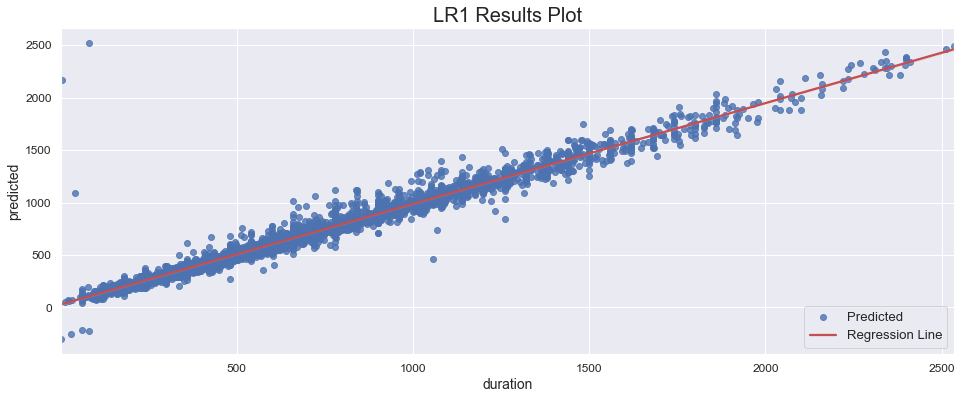

In [41]:
fig, ax = plt.subplots(figsize=(16,6))

sns.regplot(x=tableslr1.duration, y=tableslr1.predicted, data=tableslr1, line_kws={"color":"r"})
ax.set_title("LR1 Results Plot", size=20)
ax.legend(['Predicted','Regression Line'])
plt.show()

***

### SelectKBest (Univariate Feature Selection)

In [44]:
select = SelectKBest(score_func=f_regression, k=6)

In [45]:
X_kbest = select.fit_transform(X,y)

In [46]:
f_score = select.scores_
f_score

array([     7.25833489,     32.06669811,     27.78327191,     25.45024332,
            4.07699091,     44.88486364,     36.67346778,      4.47215696,
            3.07817734,     64.62060457,     35.61123369,     13.64173392,
           14.94237265,    284.00078003,    191.98736193,      1.18483939,
          364.2390683 ,    174.98375122,      7.65658506,      0.42540614,
        20342.73915597, 156771.77290142,   3221.43239598,  94956.19093193])

In [47]:
p_values = select.pvalues_
p_values

array([0.00706325, 0.00000002, 0.00000014, 0.00000046, 0.04348453,
       0.        , 0.        , 0.034464  , 0.07936496, 0.        ,
       0.        , 0.00022181, 0.0001112 , 0.        , 0.        ,
       0.27638631, 0.        , 0.        , 0.00566183, 0.51425935,
       0.        , 0.        , 0.        , 0.        ])

In [48]:
ffilter = select.get_support()
ffilter

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False,  True,  True,  True,  True])

In [49]:
features = np.array(X.columns)
features

array(['vendorid2', 'paymenttype1', 'paymenttype2', 'pulocationid237',
       'pulocationid161', 'pulocationid236', 'pulocationid186',
       'pulocationid162', 'dolocationid161', 'dolocationid236',
       'dolocationid237', 'dolocationid230', 'dolocationid170',
       'tpeppickupdatetimehour0', 'tpeppickupdatetimehour1',
       'tpeppickupdatetimehour2', 'tpepdropoffdatetimehour0',
       'tpepdropoffdatetimehour1', 'tpepdropoffdatetimehour2',
       'passengercount', 'tripdistance', 'fareamount', 'tipamount',
       'totalamount'], dtype=object)

In [50]:
# Selected features
features[ffilter]

array(['tpeppickupdatetimehour0', 'tpepdropoffdatetimehour0',
       'tripdistance', 'fareamount', 'tipamount', 'totalamount'],
      dtype=object)

In [51]:
X_kbest

array([[1.        , 0.        , 0.54220779, 0.49056604, 0.45320197,
        0.53488372],
       [0.        , 0.        , 0.29220779, 0.60377358, 0.65681445,
        0.67183463],
       [1.        , 1.        , 0.16233766, 0.24528302, 0.23809524,
        0.28262274],
       ...,
       [0.        , 0.        , 0.06818182, 0.16981132, 0.        ,
        0.17118863],
       [0.        , 0.        , 0.38311688, 0.39622642, 0.27914614,
        0.41989664],
       [0.        , 0.        , 0.34090909, 0.41509434, 0.38587849,
        0.45704134]])

In [52]:
X_kbest.shape

(19692, 6)

## Linear Regression Model 2

In [53]:
# After feature selection
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2, random_state=0)

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15753, 6), (3939, 6), (15753,), (3939,))

In [55]:
lr2 = LinearRegression()

In [56]:
lr2.fit(X_train,y_train)

LinearRegression()

In [57]:
lr2_pred = lr2.predict(X_test)
lr2_pred[0:5]

array([ 323.18847571,  272.83735646,  818.99675552,  900.66744914,
       1237.36086373])

In [58]:
lr2.intercept_

-283.5591858965381

In [59]:
lr2.coef_

array([   -3.36711741,   -16.88406313, -1234.23814745,  3292.70457878,
         -74.62899516,   399.0207346 ])

### Linear Regression 2 Evaluation

In [60]:
mse = mean_squared_error(y_test,lr2_pred)
mse

6766.919750429907

In [61]:
rmse = np.sqrt(mse)
rmse

82.26128950138033

In [62]:
r2score = r2_score(y_test,lr2_pred)
r2score

0.9633560066405328

In [63]:
# Get the shape of x, to facilitate the creation of the Adjusted R^2 metric
X.shape

(19692, 24)

In [64]:
X_select.shape

(19692, 21)

In [65]:
# Number of observations is the shape along axis 0
n = X.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X.shape[1]

In [66]:
# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2score)*(n-1)/(n-p-1)
adjusted_r2

0.9633112893048625

In [67]:
lr2.score(X_train, y_train)

0.9617380603799737

In [68]:
lr2.score(X_test, y_test)

0.9633560066405328

In [69]:
prediction = pd.DataFrame(data=lr2_pred, columns=['predicted'])
prediction

,predicted
0,323.19
1,272.84
2,819.00
3,900.67
4,1237.36
...,...
3934,668.94
3935,1229.85
3936,656.54
3937,782.01


In [70]:
y_test.reset_index(drop=True, inplace=True)
y_test

0       331.00
1       180.00
2       803.00
3       840.00
4      1277.00
         ...  
3934    720.00
3935   1200.00
3936    720.00
3937    780.00
3938   1192.00
Name: duration, Length: 3939, dtype: float64

In [71]:
tableslr2 = pd.concat([y_test, prediction], axis=1)
tableslr2

,duration,predicted
0,331.00,323.19
1,180.00,272.84
2,803.00,819.00
3,840.00,900.67
4,1277.00,1237.36
...,...,...
3934,720.00,668.94
3935,1200.00,1229.85
3936,720.00,656.54
3937,780.00,782.01


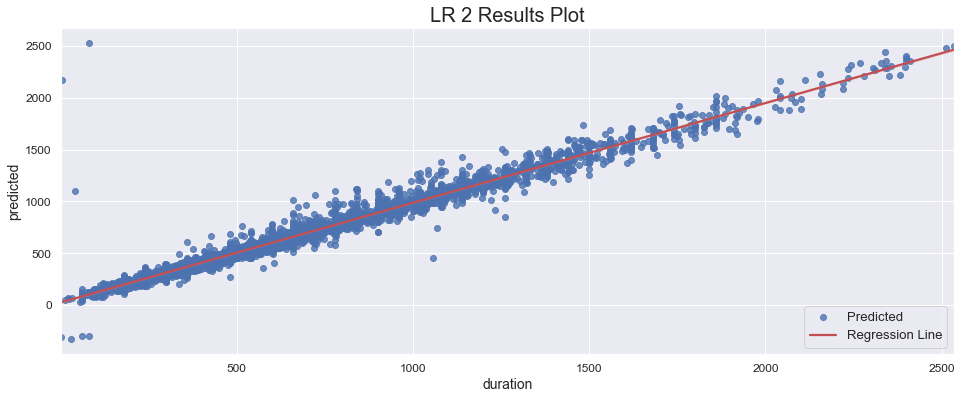

In [72]:
fig, ax = plt.subplots(figsize=(16,6))

sns.regplot(x=tableslr2.duration, y=tableslr2.predicted, data=tableslr2, line_kws={"color":"r"})
ax.set_title("LR 2 Results Plot", size=20)
ax.legend(['Predicted','Regression Line'])
plt.show()

***

### Recursive Feature Elimination

In [ ]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=6, verbose=1, step=1)

In [ ]:
rfe.fit(X,y)

In [ ]:
rfe.ranking_

In [ ]:
rfe.support_

In [ ]:
ffilter = rfe.support_
ffilter

In [ ]:
features = np.array(X.columns)
features

In [ ]:
# Selected features
features[ffilter]

In [ ]:
rfe.transform(X)

In [ ]:
X_select = rfe.transform(X)

In [ ]:
X_select

### Variance Threshold

Remember we should apply the variance filter only on numerical variables.

Default Value of Threshold is 0

    If Variance Threshold = 0 (Remove Constant Features )
    If Variance Threshold > 0 (Remove Quasi-Constant Features )


In [ ]:
#X.dtypes

In [ ]:
#X.var(axis=0, skipna=True, level=None, ddof=1, numeric_only=None) 

In [ ]:
threshold_n=0.95

vt = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))

In [ ]:
vtfit = vt.fit(X,y)

In [ ]:
vtfit.variances_

In [ ]:
vt.get_support()

In [ ]:
vt.get_feature_names_out()

***

### SelectFromModel

In [73]:
X = df.iloc[:,0:24]
y = df.iloc[:,24]

In [74]:
X.values, y.values

(array([[1.        , 1.        , 0.        , ..., 0.49056604, 0.45320197,
         0.53488372],
        [0.        , 1.        , 0.        , ..., 0.60377358, 0.65681445,
         0.67183463],
        [0.        , 1.        , 0.        , ..., 0.24528302, 0.23809524,
         0.28262274],
        ...,
        [1.        , 0.        , 1.        , ..., 0.16981132, 0.        ,
         0.17118863],
        [1.        , 1.        , 0.        , ..., 0.39622642, 0.27914614,
         0.41989664],
        [0.        , 1.        , 0.        , ..., 0.41509434, 0.38587849,
         0.45704134]]),
 array([ 844., 1560.,  432., ...,  240.,  716.,  840.]))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [76]:
# we train a Linear regression model and select
# features with higher coefficients.

# the LinearRegression object from sklearn is a non-regularised
# linear method. It fits by matrix multiplication and not 
# gradient descent.

# therefore we don't need to specify penalty and other parameters

selfm = SelectFromModel(LinearRegression())

In [77]:
selfm.fit(X_train,y_train)

SelectFromModel(estimator=LinearRegression())

In [78]:
# let's count the number of variables selected
selected_feat = X_train.columns[(selfm.get_support())]

len(selected_feat)

3

In [79]:
selected_feat

Index(['tripdistance', 'fareamount', 'totalamount'], dtype='object')

In [80]:
selected_feat.shape

(3,)

In [81]:
X

,vendorid2,paymenttype1,paymenttype2,pulocationid237,pulocationid161,pulocationid236,pulocationid186,pulocationid162,dolocationid161,dolocationid236,dolocationid237,dolocationid230,dolocationid170,tpeppickupdatetimehour0,tpeppickupdatetimehour1,tpeppickupdatetimehour2,tpepdropoffdatetimehour0,tpepdropoffdatetimehour1,tpepdropoffdatetimehour2,passengercount,tripdistance,fareamount,tipamount,totalamount
0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.00,0.54,0.49,0.45,0.53
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.17,0.29,0.60,0.66,0.67
2,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0.17,0.16,0.25,0.24,0.28
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.17,0.71,0.62,0.00,0.57
4,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1.00,0.37,0.34,0.34,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19687,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0.17,0.14,0.28,0.29,0.34
19688,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.50,0.10,0.15,0.00,0.19
19689,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.17,0.07,0.17,0.00,0.17
19690,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.17,0.38,0.40,0.28,0.42


In [82]:
X_coeff = X[['tripdistance', 'fareamount', 'totalamount']]

In [83]:
# After feature selection
X_train, X_test, y_train, y_test = train_test_split(X_coeff, y, test_size=0.2, random_state=0)

In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15753, 3), (3939, 3), (15753,), (3939,))

## Linear Regression Model 3

In [85]:
lr3 = LinearRegression()

In [86]:
lr3.fit(X_train,y_train)

LinearRegression()

In [87]:
lr3_pred = lr3.predict(X_test)
lr3_pred[0:5]

array([ 320.18123995,  272.47733203,  815.45792389,  894.00483531,
       1231.78651534])

In [88]:
lr3.intercept_

-278.4785754045971

In [89]:
lr3.coef_

array([-1247.23537946,  3571.3365386 ,    85.82347751])

### Linear Regression Evaluation

In [90]:
mse = mean_squared_error(y_test,lr3_pred)
mse

6809.31915291639

In [91]:
rmse = np.sqrt(mse)
rmse

82.51859883030244

In [92]:
r2score = r2_score(y_test,lr3_pred)
r2score

0.9631264068402601

In [93]:
# Get the shape of x, to facilitate the creation of the Adjusted R^2 metric
X.shape

(19692, 24)

In [94]:
X_select.shape

(19692, 21)

In [95]:
# Number of observations is the shape along axis 0
n = X.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X.shape[1]

In [96]:
# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2score)*(n-1)/(n-p-1)
adjusted_r2

0.963081409319752

In [97]:
lr3.score(X_train, y_train)

0.961232706898352

In [98]:
lr3.score(X_test, y_test)

0.9631264068402601

In [99]:
prediction = pd.DataFrame(data=lr3_pred, columns=['predicted'])
prediction

,predicted
0,320.18
1,272.48
2,815.46
3,894.00
4,1231.79
...,...
3934,665.91
3935,1234.33
3936,654.27
3937,769.92


In [100]:
y_test.reset_index(drop=True, inplace=True)
y_test

0       331.00
1       180.00
2       803.00
3       840.00
4      1277.00
         ...  
3934    720.00
3935   1200.00
3936    720.00
3937    780.00
3938   1192.00
Name: duration, Length: 3939, dtype: float64

In [101]:
tableslr3 = pd.concat([y_test, prediction], axis=1)
tableslr3

,duration,predicted
0,331.00,320.18
1,180.00,272.48
2,803.00,815.46
3,840.00,894.00
4,1277.00,1231.79
...,...,...
3934,720.00,665.91
3935,1200.00,1234.33
3936,720.00,654.27
3937,780.00,769.92


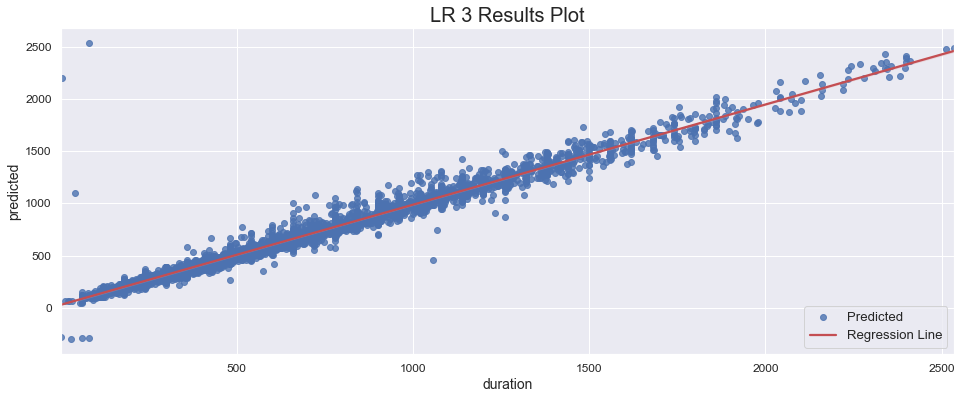

In [102]:
fig, ax = plt.subplots(figsize=(16,6))

sns.regplot(x=tableslr3.duration, y=tableslr3.predicted, data=tableslr3, line_kws={"color":"r"})
ax.set_title("LR 3 Results Plot", size=20)
ax.legend(['Predicted','Regression Line'])
plt.show()

***

## K Fold Cross Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=5 becoming 5-fold cross-validation, as shown in the Diagram below. In this case, we would use K-1 (or 4 folds) for testing a 1 fold for training. K-fold is also used for hyper-parameters selection that we will discuss later.

<img src="k-fold.png">

In many cases, we would like to train models that are not available in Scikit-learn or are too large to fit in the memory. We can create a `KFold` object that  Provides train/test indices to split data into train/test sets in an iterative manner.

`n_splits`:  A number of folds. Must be at least 2. Changed in version 0.22: n_splits default value changed from 3 to 5.

`shuffle`: Indicates whether to shuffle the data before splitting into batches. Note, the samples within each split will not be shuffled.

`random_state`: the random state.

In [103]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [104]:
lr3_pred = cross_val_predict(lr3, X, y, cv=kf, n_jobs=-1)

In [106]:
r2_score(y, lr3_pred)

0.9621207350116033

## Cross Validation Score

Now, let's use *Scikit-Learn's* *K-fold cross-validation* method to see whether we can assess the performance of our model. The *K-fold cross-validation* method splits the training set into the number of folds (n_splits), as now in the Diagram above, if we have K folds, K-1 is used for training and one fold is used for testing. The input parameters are as follows:

<b>estimator</b>: The object to use to `fit` the data.

<b>X</b>: array-like of shape (n_samples, n_features). The data to fit. Can be for example a list, or an array.

<b>y</b>: array-like of shape (n_samples,) or (n_samples, n_outputs), default=None. The target variable to try to predict in the case of supervised learning.

<b>scoring</b>: A str or a scorer callable object/ function with signature scorer (estimator, X, y) which should return only a single value.  See model evaluation [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML240ENSkillsNetwork34171862-2022-01-01#scoring-parameter) for more information.

The larger the fold, the better the model performance is, as we are using more samples for training; the variance also decreases.


In [107]:
cv = cross_val_score(estimator=lr3, X=X_train, y=y_train, scoring='r2', cv=5)

In [108]:
cv.mean()

0.961013054481356

In [109]:
cv.std()

0.006780459797965663

You can also use the function 'cross_val_predict' to predict the output. The function splits up the data into the specified number of folds, with one fold for testing and the other folds are used for training.

In [ ]:
lr_pred_cv = cross_val_predict(estimator=lr, X=X_train[["disp"]], y=y_train, cv=5)

In [ ]:
lr_pred_cv [0:5]

***

## Create a random dataset for Hyperparameter Tuning

In [119]:
df_random = pd.concat([X_coeff, y], axis = 1)

In [120]:
df_random.head()

,tripdistance,fareamount,totalamount,duration
0,0.54,0.49,0.53,844.00
1,0.29,0.60,0.67,1560.00
2,0.16,0.25,0.28,432.00
3,0.71,0.62,0.57,1003.00
4,0.37,0.34,0.40,480.00


In [125]:
df_random = df_random.sample(frac=0.25, replace=True, random_state=0)

In [126]:
df_random

,tripdistance,fareamount,totalamount,duration
2234,0.58,0.47,0.45,722.00
17390,0.88,0.68,0.72,838.00
15270,0.11,0.15,0.19,117.00
2807,0.42,0.40,0.38,660.00
7494,0.39,0.45,0.45,847.00
...,...,...,...,...
9519,0.22,0.30,0.34,571.00
2522,0.62,0.53,0.60,948.00
4727,0.14,0.21,0.26,308.00
14287,0.29,0.36,0.38,660.00


In [127]:
X_random = df_random.iloc[:,:3]
y_random = df_random.iloc[:,3]

In [128]:
X_random.values, y_random.values

(array([[0.58116883, 0.47169811, 0.44573643],
        [0.87662338, 0.67924528, 0.72028424],
        [0.11363636, 0.1509434 , 0.18572351],
        ...,
        [0.13636364, 0.20754717, 0.26356589],
        [0.29220779, 0.35849057, 0.38275194],
        [0.21103896, 0.37735849, 0.34883721]]),
 array([722., 838., 117., ..., 308., 660., 840.]))

In [129]:
X_random_train, X_random_test, y_random_train, y_random_test = train_test_split(X_random, y_random, test_size=0.2, random_state=0)

In [130]:
X_random_train.shape, X_random_test.shape, y_random_train.shape, y_random_test.shape

((3938, 3), (985, 3), (3938,), (985,))

## Regularization Techniques

The purpose of Regularization techniques is to reduce the degree of overfitting that can occur in Regression models. Overfitting leads to poor ability of the model to make predictions on the new, unseen data. As we saw in the previous Regression Lessons, with a creation of extra features, such as through polynomial regression, a model can become easily overfit. To reduce the overfitting, we can regularize the model, or in other words, we can decrease its degrees of freedom. A simple way to regularize polynomial model is to reduce the number of polynomial degrees. For a linear regression model, regularization is typically achieved by constraining the weights of the model. Regularizer imposes a penalty on the size of the coefficients of the model.

In this lab, we will cover three types of regularizers:

*   Ridge regression
*   Lasso regression
*   Elastic Net

Each one has its own advantages and disadvantages. Lasso will eliminate many features and reduce overfitting in your linear model. Ridge will reduce the impact of the features that are not important in predicting your target. Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model’s predictions.

The common features of all these regularizers include using cross-validation to select hyperparameters and applying data normalization to improve the performance.

## Lasso Regression

In this section, let's review the Lasso (Least Absolute Shrinkage and Selection Operator) Regression. Lasso Regression makes the prior assumption that our coefficients have Laplace (double-exponential) distribution around zero. The scale parameter of the distribution is inversely proportional to the parameter alpha. The main advantage of LASSO Regression is that many coefficients are set to zero, therefore they are not required. This has many advantages, one of them is that you may not need to collect and/or store all of the features. This may save resources. For example, if the feature was some medical test, you would no longer need to perform that test. Let's see how the parameter alpha changes the model.  We minimize the MSE, but we also penalize large weights by including their sum of absolute values $||\textbf{w}||_1$ , symbolically:

$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  ||\textbf{w}||_1 }$

This regularization or penalty term makes many coefficients zero, making the model easy to understand and can also be used for feature selection. There are some drawbacks to this technique. It takes longer time to train and the solution may not be unique. Alpha controls the trade-off between MSE and penalization or regularization term and is chosen via cross-validation.  Let's see how the parameter alpha changes the model. Note, as before, our test data will be used as validation data. Let's create a Lasso Regression object, setting the regularization parameter (alpha) to 0.01.

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
X = df.iloc[:,0:24]
y = df.iloc[:,24]

In [ ]:
X.values, y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
lassoreg = Lasso(alpha = 1.0, max_iter=1000, random_state=None)

In [ ]:
lassoreg.fit(X_train,y_train)

In [ ]:
lassoreg.coef_

In [ ]:
lassoreg.intercept_

In [ ]:
lasso_predict = lassoreg.predict(X_test)
lasso_predict[0:5]

### Lasso Regression Evaluation

In [ ]:
mse = mean_squared_error(y_test,lasso_predict)
mse

In [ ]:
rmse = np.sqrt(mse)
rmse

In [ ]:
r2score = r2_score(y_test,lasso_predict)
r2score

In [ ]:
# Get the shape of x, to facilitate the creation of the Adjusted R^2 metric
X.shape

In [ ]:
# Number of observations is the shape along axis 0
n = X.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X.shape[1]

In [ ]:
# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2score)*(n-1)/(n-p-1)
adjusted_r2

## Lasso regularisation

Regularisation consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and avoid overfitting. In linear model regularization, the penalty is applied to the coefficients that multiply each of the predictors. The Lasso regularization or l1 has the property that is able to shrink some of the coefficients to zero. Therefore, those features can be removed from the model.

As we can see, both for linear and logistic regression we used the Lasso regularisation to remove non-important features from the dataset. 

Keep in mind that increasing the penalisation will increase the number of features removed. Therefore, you will need to keep an eye and monitor the final model performance to ensure that you don't set a penalty too high so it removes a lot of features, or too low, and thus useless features are retained.


### Select Coefficients with Lasso

In practice, feature selection should be done after data pre-processing,
so ideally, all the categorical variables are encoded into numbers,
and then you can assess how deterministic they are of the target

Separate train and test sets

the features in the house dataset are in very different scales, so it helps the regression to scale
them

here, again I will train a Lasso Linear regression and select
the non zero features in one line.

bear in mind that the linear regression object from sklearn does
not allow for regularisation. So If you want to make a regularised
linear regression you need to import specifically "Lasso"

alpha is the penalisation, so I set it high
to force the algorithm to shrink some coefficients

In [ ]:
sel_feat = SelectFromModel(Lasso(alpha=1.0, random_state=0)) # Vary the alphas

In [ ]:
sel_feat.fit(X_train, y_train)

In [ ]:
sel_feat.get_support()

In [ ]:
# make a list with the selected features and print the outputs
selected_feat = X_train.columns[(sel_feat.get_support())]

In [ ]:
selected_feat

## Ridge Regression

Let's review the Ridge Regression. Ridge Regression makes the prior assumption that our coefficients are normally distributed around zero. A regularization term, alpha, is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. The variance of the distribution is inversely proportional to the parameter alpha. This is also called the  L2 regularizer , as it adds a L2 penalty to the minimization term, as shown here:

$\hat{\textbf{w}}= \underset{\textbf{w}}{\mathrm{argmin}} {
||\textbf{y}  - \textbf{Xw} ||^2_2+ \alpha  ||\textbf{w}||_2 }$

We minimize the MSE, but we also penalize large weights by including their magnitude $||\textbf{w}||\_2$ in the minimization term. This additional minimization term makes the model less susceptible to noise and makes the weights smaller. Alpha controls the takeoff between MSE and penalization or regularization term and is chosen via cross-validation.

In [131]:
rd = Ridge(alpha=1.0, max_iter=None, random_state=0)

In [132]:
rd.fit(X_train,y_train)

Ridge(random_state=0)

In [133]:
rd_pred = rd.predict(X_test)

In [134]:
rd_pred[0:5]

array([ 318.04536501,  273.54910223,  809.16658474,  896.3420713 ,
       1234.56674552])

In [135]:
y_test[0:5]

0    331.00
1    180.00
2    803.00
3    840.00
4   1277.00
Name: duration, dtype: float64

### Ridge Regression Evaluation

In [136]:
mse = mean_squared_error(y_test,rd_pred)
mse

6872.707873843584

In [137]:
rmse = np.sqrt(mse)
rmse

82.90179656583797

In [138]:
r2score = r2_score(y_test,rd_pred)
r2score

0.962783146397638

In [139]:
# Get the shape of x, to facilitate the creation of the Adjusted R^2 metric
X.shape

(19692, 24)

In [140]:
# Number of observations is the shape along axis 0
n = X.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X.shape[1]

In [141]:
# We find the Adjusted R-squared using the formula
adjusted_r2 = 1-(1-r2score)*(n-1)/(n-p-1)
adjusted_r2

0.9627377299901301

### Perform GridSearchCV

In [142]:
parameters= [{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]
parameters

[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]

In [143]:
gs = GridSearchCV(estimator=rd, param_grid=parameters, n_jobs=-1, cv=5)

In [144]:
gs.fit(X_random_train,y_random_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=0), n_jobs=-1,
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 1000, 10000, 100000,
                                    100000]}])

In [145]:
gs.best_estimator_

Ridge(alpha=0.001, random_state=0)

In [146]:
gs.best_score_

0.9695692399483999

In [148]:
gs.best_estimator_.score(X_random_test,y_random_test)

0.9760569449777287

### Compare models

Create a table of results to compare model performance.

In [162]:
# Create a table of results to compare model performance.

### YOUR CODE HERE ###

table = pd.DataFrame()
table = table.append({'Model': "LR1",
                        'MSE':  6753.23,
                        'RMSE': 82.18,
                        'R2': 0.9634
                        
                      },
                        ignore_index=True
                    )

table = table.append({'Model': "LR2",
                        'MSE':  6766.92,
                        'RMSE': 82.26,
                        'R2': 0.9633
                      },
                        ignore_index=True
                    )

table = table.append({'Model': "LR3",
                        'MSE':  6809.32,
                        'RMSE': 82.52,
                        'R2': 0.9631
                      },
                        ignore_index=True
                    )

table

,Model,MSE,RMSE,R2
0,LR1,6753.23,82.18,0.96
1,LR2,6766.92,82.26,0.96
2,LR3,6809.32,82.52,0.96


## Conclusion: By reducing features, we can get similar results

#### Python code done by Dennis Lam